Alexander W. Criswell 9/15/25

Test notebook for the initial cupy-based implementation of pelargir-gb.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# import numpy as np
import cupy as xp
import matplotlib.pyplot as plt
from matplotlib.ticker import AutoLocator
# import jax.numpy as jnp
# import jax; jax.config.update("jax_enable_x64", True)
from corner import corner, overplot_lines
import legwork as lw
import astropy.units as u
from tqdm import tqdm
from math import factorial
plt.style.use('default')

In [3]:
from eryn.ensemble import EnsembleSampler
from eryn.state import State
from eryn.prior import ProbDistContainer, uniform_dist
from eryn.utils import TransformContainer
from eryn.moves import GaussianMove, StretchMove, CombineMove
from eryn.utils.utility import groups_from_inds
from multiprocessing import Pool

In [4]:
xp.cuda.is_available()

True

In [5]:
## set environment variables
import os
os.environ['PELARGIR_GPU'] = '1'
os.environ['SCIPY_ARRAY_API'] = '1'
os.environ['PELARGIR_ERYN'] = '1'

In [6]:
if os.environ['PELARGIR_GPU']:
    print('GPU enabled.')

GPU enabled.


In [7]:
import sys
prop_path = '/home/awc/Documents/LISA/projects/lisa_population_inference/pelargir-gb/pelargir/'
sys.path.insert(1, prop_path)
from models import PopModel
from inference import GalacticBinaryPrior, PopulationHyperPrior
from utils import get_amp_freq
import distributions as st

GPU requested and available; running Pelargir population inference on GPU.
GPU requested and available; running Pelargir population inference on GPU.
GPU requested and available; running Pelargir population inference on GPU.
GPU requested and available; running Pelargir population inference on GPU.
GPU requested and available; running Pelargir population inference on GPU.


Okay, imports successful. We're going to try to follow the toy model notebook and reproduce the results. They won't be perfectly identical, as some of the underlying sampling routines are different, but they should generally follow.

In [8]:
test_rng = xp.random.default_rng(170817)

In [9]:
test_prior = GalacticBinaryPrior(test_rng)

In [10]:
pop_theta = {'m_mu':xp.array([0.6]),'m_sigma':xp.array([0.15]),
             # 'd_mu':xp.array([30]),'d_sigma':xp.array([10]),
             'd_gamma_a':xp.array([4]),'d_gamma_b':xp.array([4]),
             'a_alpha':xp.array([1/2])}
test_prior.condition(pop_theta)

In [11]:
samps = test_prior.sample_conditional(int(1e7))

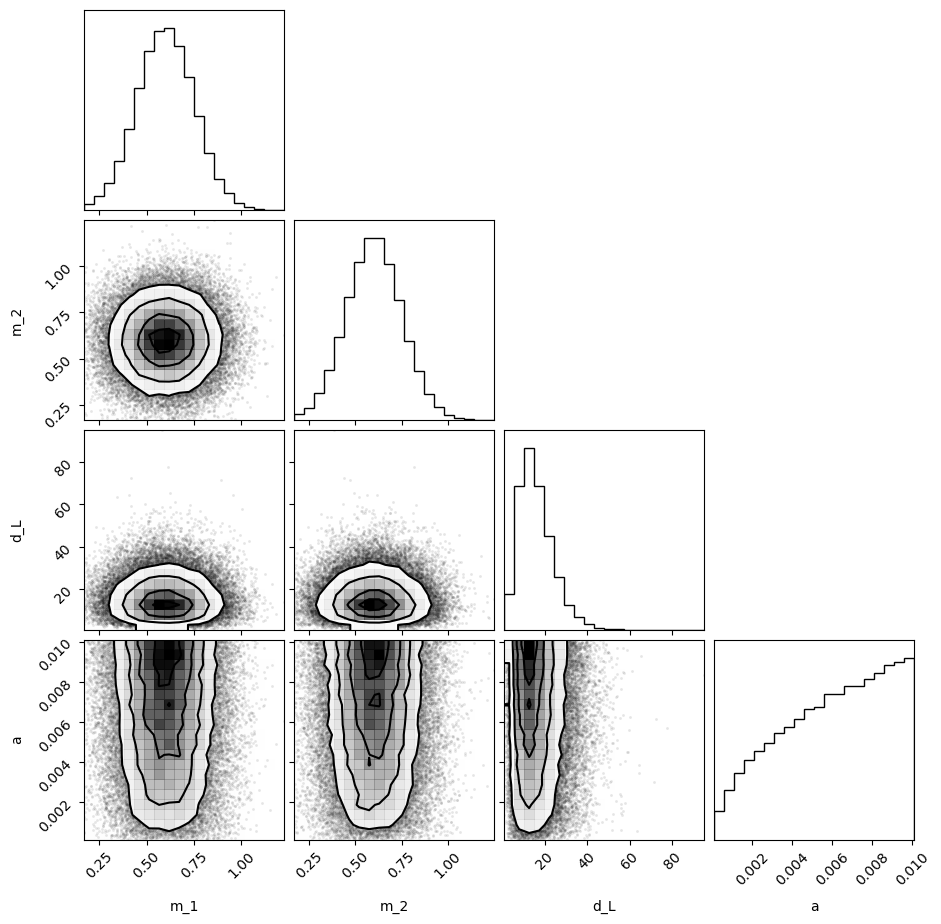

In [12]:
plt.close()
fig = corner(samps[:,::200].get().T,labels=list(test_prior.conditional_dict.keys()))
plt.show()

In [13]:
amps, fgws = get_amp_freq(samps)

Okay, good. The conditional prior class works and allows for data generation. Now let's instantiate the hyperprior for the population-level parameters,  as well as the population model:

In [14]:
test_hprior = PopulationHyperPrior(test_rng)

In [15]:
test_hprior_samples = test_hprior.sample(size=1000)

In [16]:
for key in test_hprior_samples.keys():
    test_hprior_samples[key] = test_hprior_samples[key].get()

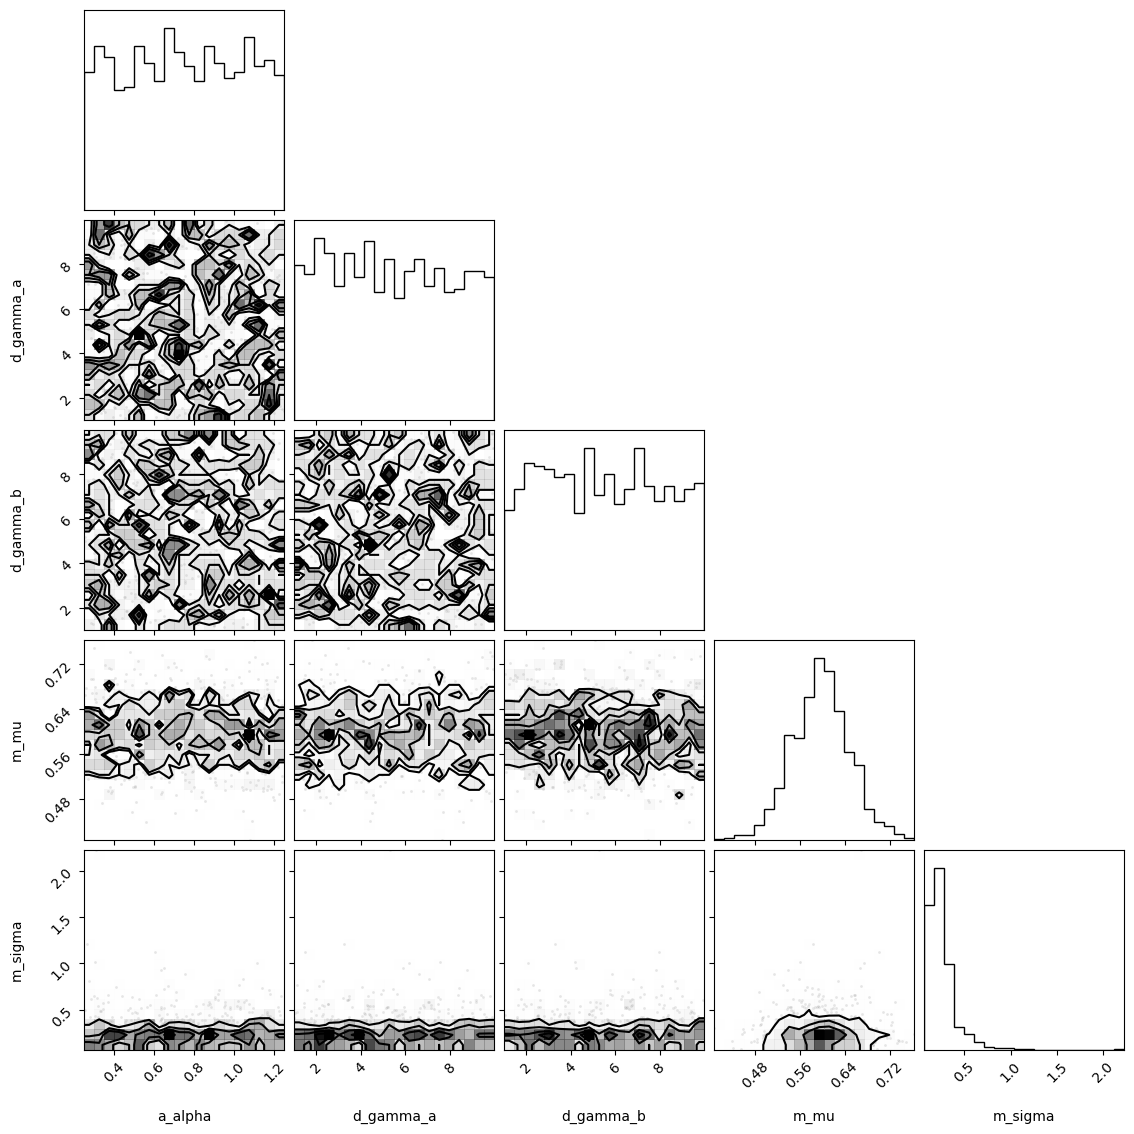

In [17]:
plt.close()
fig = corner(test_hprior_samples)

plt.show()

In [18]:
test_popmodel = PopModel(1e7,test_rng,hyperprior=test_hprior,Nsamp=1,thresh_compute_frac=1.0)

In [19]:
test_f, test_fg, N_res = test_popmodel.run_model(pop_theta)

To compare to the initial population draw, we need to run the thresholder on it.

In [20]:
data_N_res, data_coarse_fg = test_popmodel.thresher.serial_array_sort(xp.array([fgws,amps]),
                                                                      test_popmodel.fbins,
                                                                      snr_thresh=test_popmodel.thresh_val,
                                                                      compute_frac=test_popmodel.tc_frac)
data_fg = test_popmodel.reweight_foreground(data_coarse_fg)[1:]

In [21]:
data_N_res

array(923)

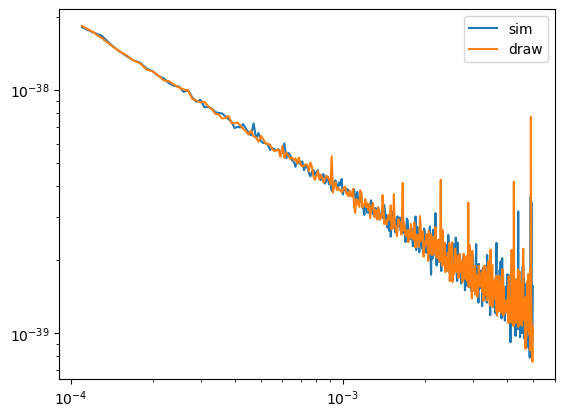

In [22]:
plt.figure()
# plt.loglog(fbins_test,xp.sqrt(0.5*(4*u.yr).to(u.s).value*fg_sort),alpha=0.5)
plt.loglog(test_f.get(),data_fg.get(),label='sim')
# plt.loglog(bins,lw.psd.lisa_psd(bins*u.Hz,t_obs=4*u.yr,confusion_noise=None).value)
plt.loglog(test_f.get(), test_fg.get(),label='draw')
# plt.scatter(binaries[0][res_idx],lw.psd.approximate_response_function(binaries[0][res_idx]*u.Hz,19.09*u.mHz).value\
#                                    *((4*u.yr).to(u.s).value*binaries[1][res_idx]**2),marker='.',s=4)
plt.legend()
plt.show()

Good. Identical up to the Poisson realization. Now check that sampling the (hyper)parameter space creates appropriate spectral spread

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:14<00:00,  1.38it/s]


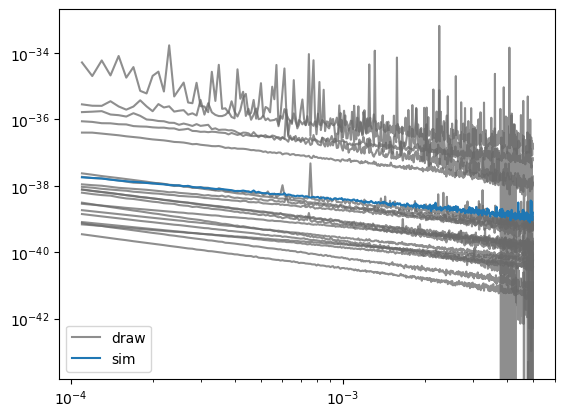

In [23]:
plt.figure()
for i in tqdm(range(20)):
    if i == 0:
        label='draw'
    else:
        label='__nolabel__'
    test_f, test_fg, _ = test_popmodel.run_model()
    plt.loglog(test_f.get(), test_fg.get(),label=label,c='dimgrey',alpha=0.75)
plt.loglog(test_f.get(),data_fg.get(),label='sim')
plt.legend()
plt.show()
    

Excellent. The code can run on my laptop GPU and nets another factor of 6 improvement in speed in that setting (we'e achieved a little over an order of magnitude improvement from the original code!). This can be expected to improve further on research-grade GPUs. Draws are still performing as expected.

Now let's check the likelihood.

In [24]:
## setup w.r.t. the data
datadict = {'fg':data_fg,
            'fg_sigma':0.1, ## sigma_fg = 0.1 dex
            'Nres':data_N_res}
test_popmodel.construct_likelihood(datadict)

In [25]:
# dir(test_popmodel)

In [26]:
# test_popmodel.fg_like.mu_vec

In [27]:
test_popmodel.Nsamp = 20
chain_out, fs, specs, Ns = test_popmodel.sample_likelihood(save_spec=True)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:14<00:00,  1.39it/s]


In [28]:
L_mask = [True if not xp.isinf(L) else False for L in chain_out[-1,:] ]

In [29]:
L_mask

[True,
 False,
 False,
 True,
 True,
 True,
 True,
 True,
 False,
 True,
 True,
 False,
 True,
 True,
 True,
 True,
 False,
 True,
 True,
 False]

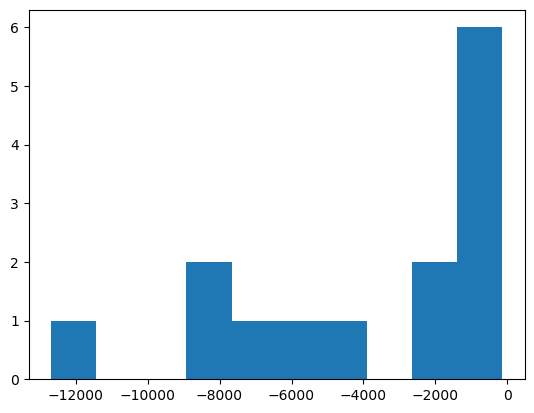

In [30]:
plt.figure()
plt.hist([L for L in chain_out[-1,:].get() if not xp.isinf(L) ])
plt.show()

In [31]:
xp.argmax(chain_out[-1,:])

array(13)

In [32]:
chain_out[-1,:]

array([ -8890.19309606,            -inf,            -inf,  -4140.94082014,
         -883.27277029,  -7151.17508587, -12680.60688927,  -1885.91904133,
                  -inf,  -6207.86986426,   -671.39239359,            -inf,
         -427.39922113,   -148.42745041,   -560.3656599 ,   -989.79564559,
                  -inf,  -1839.46967153,  -8521.13083509,            -inf])

In [33]:
Ns

[array(4110),
 array(18646),
 array(19094),
 array(4316),
 array(1012),
 array(971),
 array(7503),
 array(2603),
 array(12150),
 array(772),
 array(826),
 array(7050),
 array(211),
 array(1404),
 array(1373),
 array(1315),
 array(3924),
 array(705),
 array(294),
 array(6897)]

In [34]:
xp.asarray(Ns)[xp.argmax(chain_out[-1,:])]

array(1404)

In [35]:
xp.array(Ns)[[not L for L in L_mask]]

array([18646, 19094, 12150,  7050,  3924,  6897])

In [36]:
[key for key in test_hprior.hyperprior_dict.keys()]

['m_mu', 'm_sigma', 'd_gamma_a', 'd_gamma_b', 'a_alpha']

In [37]:
chain_out[:-1,:][:,[not L for L in L_mask]].T

array([[0.69001339, 0.21911829, 1.36870917, 9.74997968, 1.19827286],
       [0.63230095, 0.32877629, 1.28956888, 4.37809634, 1.02262882],
       [0.57594909, 0.20686381, 2.27963767, 7.94919955, 1.19929438],
       [0.58518296, 0.1998596 , 4.59578171, 4.54060455, 1.13558832],
       [0.61563598, 0.07445988, 5.44245747, 5.71819073, 1.17359699],
       [0.62581942, 0.49242986, 6.99341099, 2.48547384, 1.11860055]])

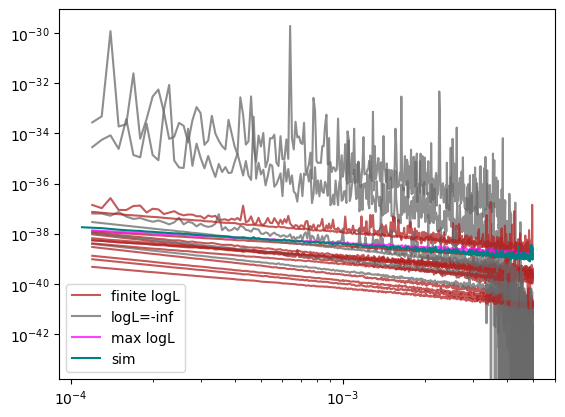

In [40]:
plt.figure()
finite_label_count = 0
inf_label_count = 0
for i in range(test_popmodel.Nsamp):
    if L_mask[i]:
        color='firebrick'
        if i==xp.argmax(chain_out[-1,:]):
            color='magenta'
            label='max logL'
        else:
            if finite_label_count == 0:
                label='finite logL'
                finite_label_count +=1
            else:
                label='__nolabel__'
    else:
        color='dimgrey'
        if inf_label_count == 0:
            label='logL=-inf'
            inf_label_count +=1
        else:
            label='__nolabel__'
        
    plt.loglog(fs, specs[i],label=label,c=color,alpha=0.75)
plt.loglog(test_f.get(),data_fg.get(),label='sim',c='teal')
plt.legend()
plt.show()

All still performing as expected and as it did on CPU.

Test Eryn interface:

In [41]:
ndim = len(test_popmodel.hyperprior.hyperprior_dict)
nwalkers = 10

In [42]:
test_rng = xp.random.default_rng(42)

In [43]:
translation_dict = {0:'m_mu',
                    1:'m_sigma',
                    2:'d_gamma_a',
                    3:'d_gamma_b',
                    4:'a_alpha'}
## starting with the broader priors
eryn_hyperprior_dict = {0:st.uniform(test_rng,loc=0.5,scale=0.2,cast=True),
                        1:st.invgamma(test_rng,5,cast=True),
                        2:st.uniform(test_rng,loc=2.5,scale=3,cast=True), ## these are pretty arbitrary
                        3:st.uniform(test_rng,loc=2.5,scale=3,cast=True), ## these are pretty arbitrary
                        4:st.uniform(test_rng,0.25,0.75,cast=True)}
eryn_trans_dict = {translation_dict[key]:eryn_hyperprior_dict[key] for key in eryn_hyperprior_dict.keys()}

In [44]:
eryn_trans_dict

{'m_mu': <distributions.uniform at 0x732cd14737a0>,
 'm_sigma': <distributions.invgamma at 0x732cd1470740>,
 'd_gamma_a': <distributions.uniform at 0x732cd14716d0>,
 'd_gamma_b': <distributions.uniform at 0x732cba1eac90>,
 'a_alpha': <distributions.uniform at 0x732cba1e9370>}

In [45]:
eryn_prior = ProbDistContainer(eryn_hyperprior_dict)

In [46]:
eryn_popmodel = PopModel(1e7,test_rng,hyperprior=eryn_trans_dict)

In [47]:
eryn_popmodel.construct_likelihood(datadict)

In [48]:
log_like_fn = eryn_popmodel.fg_N_ln_prob

In [49]:
# pool = Pool(nwalkers)

In [50]:
ensemble = EnsembleSampler(nwalkers,
                            ndim,
                            log_like_fn,
                            eryn_prior)
                            # pool=pool)

In [52]:
# starting positions
# randomize throughout prior
coords = eryn_prior.rvs(size=(nwalkers,))
# print(coords[i],type(coords[i]))
# check log_like, forcing the initialization to have finite log likelihood
log_like=xp.empty(nwalkers)
for i in tqdm(range(nwalkers)):
    log_like[i] = log_like_fn(coords[i])
    while xp.isinf(log_like[i]):
        coords[i] = eryn_prior.rvs(1)
        log_like[i] = log_like_fn(coords[i])
# log_like = xp.asarray([
#     log_like_fn(coords[i])#, means, invcov)
# for i in range(nwalkers)])
print("Log-likelihood:\n", log_like)

# check log_prior
log_prior = xp.asarray([
    eryn_prior.logpdf(coords[i])
for i in range(nwalkers)])
print("\nLog-prior:\n", log_prior)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:08<00:00,  1.16it/s]

Log-likelihood:
 [-1303.08389887 -2335.88814816  -539.53553214  -325.45053568
 -1327.26078461  -231.61900419 -1449.69399694   -76.72174154
  -403.24122595  -226.67258664]

Log-prior:
 [1.53235784 1.56162451 0.51641386 0.99749567 0.85935848 1.26748629
 1.42100109 1.36999213 0.82417962 1.57167855]


In [53]:
nsteps = 100
burn = None
thin_by = 1
out = ensemble.run_mcmc(coords, nsteps, burn=burn, progress=True, thin_by=thin_by)
# pool.close()
# pool.join()

  2%|████                                                                                                                                                                                                    | 2/100 [00:09<07:30,  4.59s/it]/home/awc/.local/share/mamba/envs/gwenv-1/lib/python3.12/site-packages/eryn/moves/move.py:515: RuntimeWarning: invalid value encountered in multiply
  temp_change_log_like = new_log_likes * (accepted_temp) + old_log_likes * (
  5%|██████████                                                                                                                                                                                              | 5/100 [00:23<07:31,  4.75s/it]/home/awc/.local/share/mamba/envs/gwenv-1/lib/python3.12/site-packages/eryn/ensemble.py:1267: UserWarning: All points input for the Likelihood have a log prior of -inf.
  warnings.warn(
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████

In Eryn, we get an overall factor of $\sim 3$ improvement in raw speed on my laptop GPU (Nvidia 4070). It is important to note that this includes a reduction in efficiency due to the necessity of serial likelihood calls when performing parallel tempering on the GPU; the 1:1 comparison is 5.5 s for 10 serial steps on the GPU vs. 14 s for 10 *parallel* steps. The underlying per-step speed-up is then a factor of $\sim 30$. 

In [209]:
# pool.terminate()

In [59]:
injdict = pop_theta
truths = xp.asnumpy([injdict[key].get() for key in injdict.keys()]).flatten()

In [60]:
truths

array([0.6 , 0.15, 4.  , 4.  , 0.5 ])

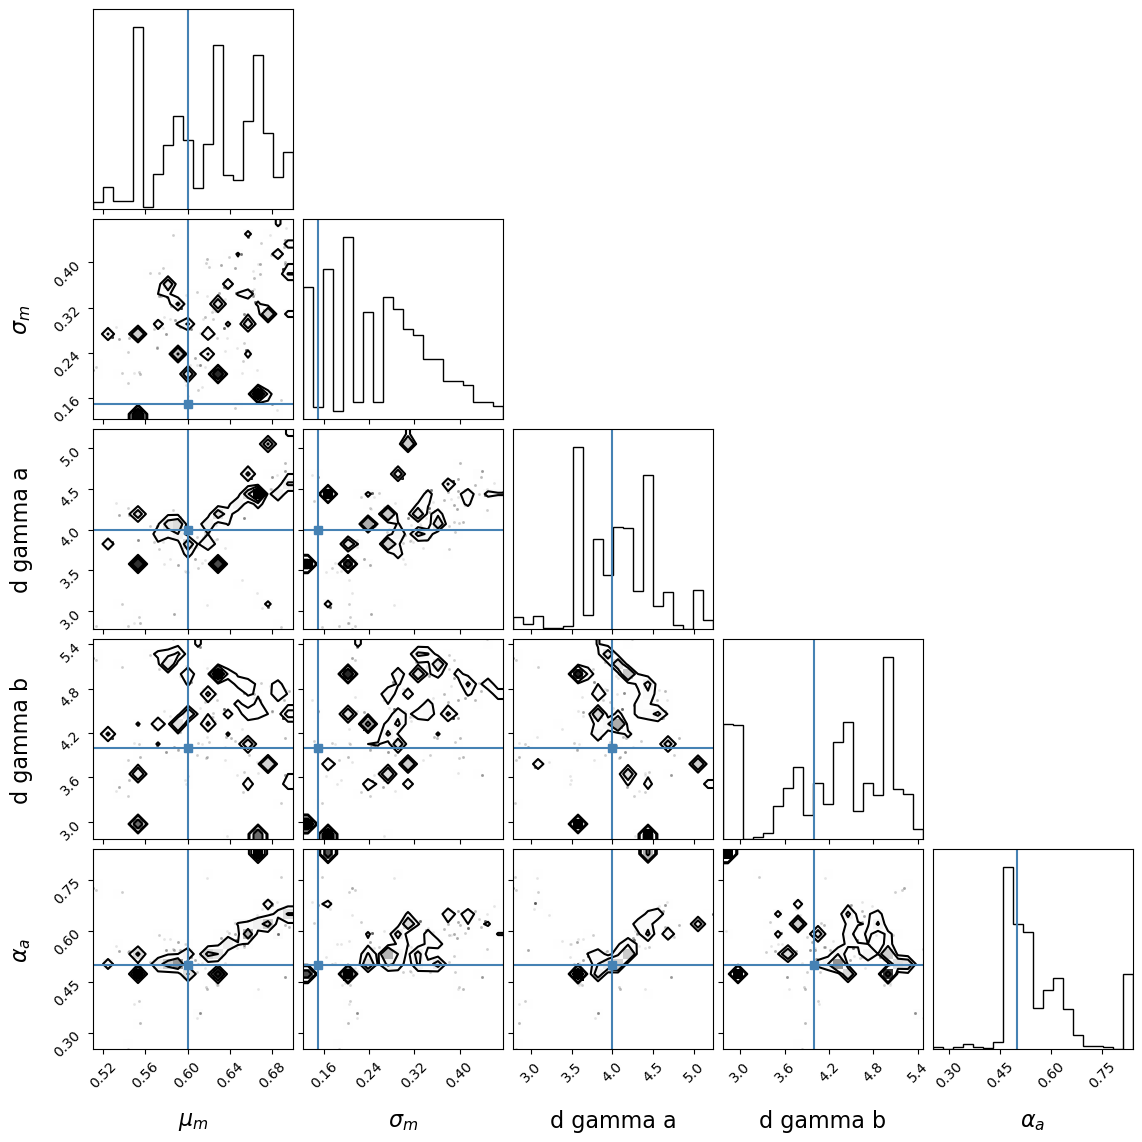

In [61]:
plt.rcParams.update({'axes.labelsize':16})
samples = ensemble.get_chain()['model_0'].reshape(-1, ndim)
corner(samples, truths=truths,labels=[r'$\mu_m$',r'$\sigma_m$',r'd gamma a',r'd gamma b',r'$\alpha_a$'])
# plt.savefig('first_initial_result.png',dpi=200)
plt.show()

We're still clearly dealing with a lot of stuck chains, as before, but this is nonetheless a proof-of-concept for the GPU implementation!